## Fitting a polygon to a point cloud
This notebook generates points around a regular polygon with added gaussian noise, and attempts to fit a hyperplane about one of the sides, then generalizes that method to fit a polygon to the points. The hyperplane to be fit consists of the set of points x which satisfy $$x^Tw+1 = 0$$
Stochastic Gradient Descent is used to find the w that minimizes
$$ Cost(w) = -\frac{1}{\left\Vert\left(Aw+b\right) \right\Vert^2+a}$$
Where the rows of $A$ are points in the point cloud, $b$ is a vector of 1's, and $a$ is a tuning parameter that limits the peak attractive force. This cost funciton is inspired by electrostatic attraction between charged particles. In a sense, this algorithm runs a simulation where each datapoint is given a finite charge, and a massless rod with the opposite charge is dropped on top, then the best fit is determined by where the rod snaps into place. With this model, points near our rod will weigh more heavily on the rod's final resting point than the others. This is not a convex cost function, so many local minima exist, as expected. With random initialization of w, more local optima can be discovered.

This method can be generalized for arbitrary dimensions, though doing so would require new methods to generate a point cloud.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def generatePolygon(n):
    assert n >= 3
    a = 2*np.pi / n
    rot = np.array([[np.cos(a),-np.sin(a)],
                     [np.sin(a), np.cos(a)]])
    start = np.array([1,0])
    corners = np.asarray([np.linalg.matrix_power(rot,i).dot(start) for i in range(n)])
    return corners

def generateNoisyPolygonCloud(n, num_points, sigma):
    corners = generatePolygon(n)
    points = []
    for i in range(num_points):
        edge_num = np.random.randint(n)
        edge = [corners[edge_num], corners[(edge_num+1)%n]]
        alpha = np.random.rand()
        points.append(alpha * edge[0] + (1-alpha) * edge[1] + sigma * np.random.randn(2))
    return np.asarray(points)



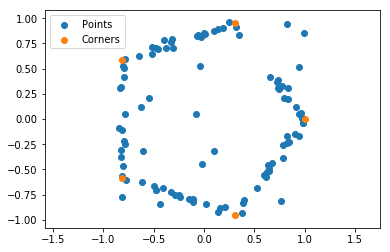

In [3]:
'''Generate Polygon'''
num_corners = 5
num_points = 100
num_popcorn_noise = 20
noise_sigma = .02

Points = generateNoisyPolygonCloud(num_corners, num_points, noise_sigma)
Corners = generatePolygon(num_corners) #display purposes
Points[:num_popcorn_noise] = np.random.uniform(-1,1,Points[:num_popcorn_noise].shape)

'''Display Polygon'''
plt.scatter(*Points.T, label='Points')
plt.scatter(*Corners.T, label='Corners')
plt.axis('equal')
plt.legend()
plt.show()

## Solving for best fit for one side

gradient: [-1.76858528e-13 -1.08302256e-13]
loss: -0.08229933637510216
w: [-1.08348892  0.6523917 ]
null: [0.51583134 0.85669016]
center: [ 0.67736551 -0.40785617]


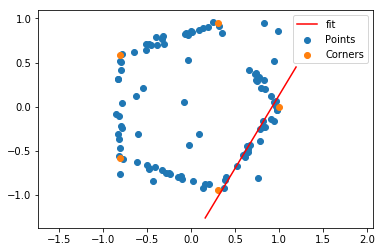

In [4]:
'''Tuning Parameters'''
a = .1
num_sgd_iterations = 5000
learning_rate = 0.0005

'''reset w'''
w = np.random.randn(2)

'''Inverse Square SGD'''
A = Points
b = np.ones(A.shape[0])
for _ in range(num_sgd_iterations):
    gradient = 2*(((A.dot(w) + b)**2+a)**-2*(A.dot(w) + b)).dot(A)
    w -= learning_rate * gradient
    
print("gradient:", gradient)
print("loss:",-1/(np.linalg.norm(A.dot(w)+b)+a))

'''display fit'''
null_w = np.array([w[1], -w[0]])/np.linalg.norm(w)
center_w = -w/(w.dot(w))
line = np.outer(null_w, np.linspace(-1,1,2)) + np.outer(center_w, np.ones(2))
print("w:",w)
print("null:", null_w)
print("center:",center_w)
plt.scatter(*Points.T, label='Points')
plt.scatter(*Corners.T, label='Corners')
plt.plot(*line, label='fit', color = 'r')
plt.axis('equal')
plt.legend()
plt.show()

## Fitting to a regular polygon, sorting by least average L1 norm for all sides.

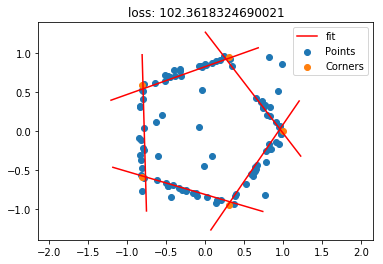

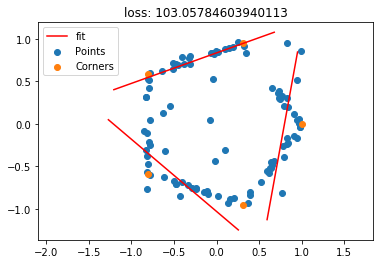

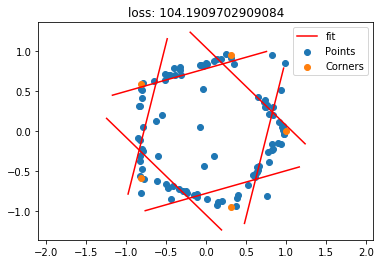

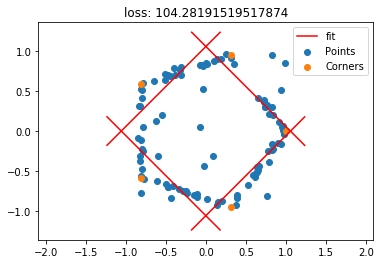

In [5]:
'''Tuning Parameters'''
a = .1
num_sgd_iterations = 5000
learning_rate = 0.0005

possible_solutions = []
for sides in range(3,7):
    '''Trying to fit shape'''
    ang = 2*np.pi / sides
    rot = np.array([[np.cos(ang),-np.sin(ang)],
                     [np.sin(ang), np.cos(ang)]])

    '''reset w'''
    w = np.random.randn(2)

    '''Inverse Square SGD'''
    A = Points
    b = np.ones(A.shape[0])
    for _ in range(num_sgd_iterations):
        gradient = 0
        for i in range(sides):
            rotation = np.linalg.matrix_power(rot,i)
            r = rotation.dot(w)
            gradient += rotation.T.dot(2*(((A.dot(r) + b)**2+a)**-2*(A.dot(r) + b)).dot(A))
        w -= learning_rate * gradient / sides
        
    loss = 0
    for i in range(sides):
        rotation = np.linalg.matrix_power(rot,i)
        r = rotation.dot(w)
#         loss += -1/(np.linalg.norm(A.dot(r)+b)+a)
        loss += np.linalg.norm(A.dot(r)+b,1)
    loss /= sides
    possible_solutions.append([loss, sides, w])
    
'''get best solution'''
possible_solutions.sort()
for solution in possible_solutions:
    loss, sides, w = solution
    ang = 2*np.pi / sides
    rot = np.array([[np.cos(ang),-np.sin(ang)],
                     [np.sin(ang), np.cos(ang)]])

    '''display fit'''
    null_w = np.array([w[1], -w[0]])/np.linalg.norm(w)
    center_w = -w/(w.dot(w))
    line = np.outer(null_w, np.linspace(-1,1,2)) + np.outer(center_w, np.ones(2))
    plt.scatter(*Points.T, label='Points')
    plt.scatter(*Corners.T, label='Corners')
    for i in range(sides):
        line = rot.dot(line)
        plt.plot(*line, label='fit', color = 'r')
    plt.axis('equal')
    plt.title("loss: " + str(loss))
    plt.legend()
    plt.show()

In [282]:
possible_solutions

















[[-0.07708474322772203, 6, array([-0.28354873,  1.36808043])],
 [-0.07664367517359809, 7, array([ 1.18949196, -0.7709893 ])],
 [-0.07655745747589118, 3, array([1.36312147, 0.41238645])],
 [-0.07644348206010412, 8, array([-1.42654831, -0.02436139])],
 [-0.07597702033701884, 5, array([ 0.52564043, -1.34955469])],
 [-0.07578566414968607, 4, array([ 1.06411318, -0.99565012])]]